In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from sqlalchemy import create_engine
from config import username, password

engine = create_engine('postgresql://{}:{}@localhost:5432/cali_renewable_db'.format(username,password))
con = engine.connect()

sql_prod = '''Select * From  "Production".hourlyrenewable'''

full_data = pd.read_sql(sql=sql_prod,con=con)
full_data['date'] = pd.to_datetime(full_data['date'])

display(full_data.head())

sql_demand = 'Select * From "Demand".hourlydemand'
demand_data = pd.read_sql(sql=sql_demand, con=con)

demand_data['date'] = pd.to_datetime(demand_data['date'])
demand_data['YEAR'] = demand_data['date'].dt.year

demand_data.head()

timestamp       date  Hour  TOTAL  SOLAR TOTAL  SOLAR PV  \
0 2015-06-01 00:00:00 2015-06-01     1   4669            0         0   
1 2015-06-01 01:00:00 2015-06-01     2   4396            0         0   
2 2015-06-01 02:00:00 2015-06-01     3   4197            0         0   
3 2015-06-01 03:00:00 2015-06-01     4   4059            0         0   
4 2015-06-01 04:00:00 2015-06-01     5   3694            0         0   

   SOLAR THERMAL  WIND TOTAL  GEOTHERMAL  BIOMASS  BIOGAS  SMALL HYDRO  
0              0        2942        1038      321     209          159  
1              0        2708        1040      316     210          122  
2              0        2509        1039      319     209          121  
3              0        2372        1035      320     209          123  
4              0        1973        1035      317     208          161

timestamp       date  Hour   DEMAND  YEAR
0 2019-12-29 11:00:00 2019-12-29    11  21305.0  2019
1 2019-12-29 10:00:00 2019-12-29    10  21638.0  2019
2 2019-12-29 09:00:00 2019-12-29     9  21745.0  2019
3 2019-12-29 08:00:00 2019-12-29     8  21859.0  2019
4 2019-12-29 07:00:00 2019-12-29     7  21586.0  2019

In [3]:
from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler

In [39]:
#still messing around with extra regressors 



full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

scaler = StandardScaler()

dd['cap'] = 17000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2014'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

ds         y       cap  on_season  off_season   daytime  \
0 2015-06-01 00:00:00  8.448700  9.740969       True       False -0.795932   
1 2015-06-01 01:00:00  8.388450  9.740969       True       False -0.795932   
2 2015-06-01 02:00:00  8.342125  9.740969       True       False -0.795932   
3 2015-06-01 03:00:00  8.308692  9.740969       True       False -0.795932   
4 2015-06-01 04:00:00  8.214465  9.740969       True       False -0.795932   
5 2015-06-01 05:00:00  8.228978  9.740969       True       False -0.795932   
6 2015-06-01 06:00:00  8.365905  9.740969       True       False -0.795932   
7 2015-06-01 07:00:00  8.716372  9.740969       True       False -0.795932   

   on_seasonr  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1

21015
14148
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31392 entries, 0 to 31391
Data columns (total 7 columns):
ds            31392 non-null datetime64[ns]
y             31392 non-null float64
cap           31392 non-null float64
on_season     31392 non-null bool
off_season    31392 non-null bool
daytime       31392 non-null float64
on_seasonr    31392 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB


In [40]:
model = Prophet(changepoint_range=.7,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=5,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=6)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=6)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime')
#model.add_regressor('equinox')
model.add_regressor('on_seasonr')
#model.add_regressor('year')
model.fit(dd_train)



In [41]:
future = model.make_future_dataframe(periods=365*24,freq='1H')
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 20000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)

forcast = model.predict(future)

ds     trend       cap  yhat_lower  yhat_upper  \
0 2015-06-01 00:00:00  8.367147  9.903488    8.139305    8.730721   
1 2015-06-01 01:00:00  8.367160  9.903488    8.115215    8.699892   
2 2015-06-01 02:00:00  8.367172  9.903488    8.106371    8.675228   
3 2015-06-01 03:00:00  8.367185  9.903488    8.089244    8.686506   
4 2015-06-01 04:00:00  8.367197  9.903488    8.011003    8.614761   

   trend_lower  trend_upper  additive_terms  additive_terms_lower  \
0     8.367147     8.367147        0.076099              0.076099   
1     8.367160     8.367160        0.051300              0.051300   
2     8.367172     8.367172        0.035500              0.035500   
3     8.367185     8.367185        0.017892              0.017892   
4     8.367197     8.367197       -0.041276             -0.041276   

   additive_terms_upper  ...  on_seasonr  on_seasonr_lower  on_seasonr_upper  \
0              0.076099  ...     0.11084           0.11084           0.11084   
1              0.051300  ...     0.11084           0.11084           0.11084   
2              0.035500  ...     0.11084           0.11084           0.11084   
3              0.017892  ...     0.11084           0.11084           0.11084   
4             -0.041276  ...     0.11084           0.11084           0.11084   

     yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  0.356211      0.356211      0.356211                   0.0   
1  0.353853      0.353853      0.353853                   0.0   
2  0.351374      0.351374      0.351374                   0.0   
3  0.348796      0.348796      0.348796                   0.0   
4  0.346141      0.346141      0.346141                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                         0.0                         0.0  8.443246  
1                         0.0                         0.0  8.418459  
2                         0.0                         0.0  8.402672  
3                         0.0                         0.0  8.385077  
4                         0.0                         0.0  8.325922  

[5 rows x 32 columns]

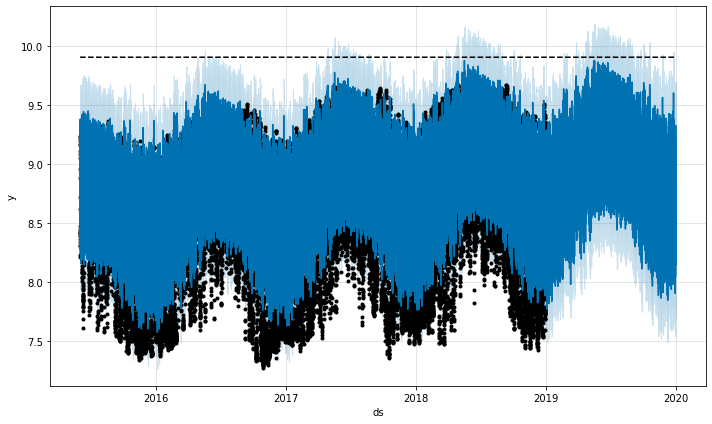

In [42]:
model.plot(forcast)
forcast.head()


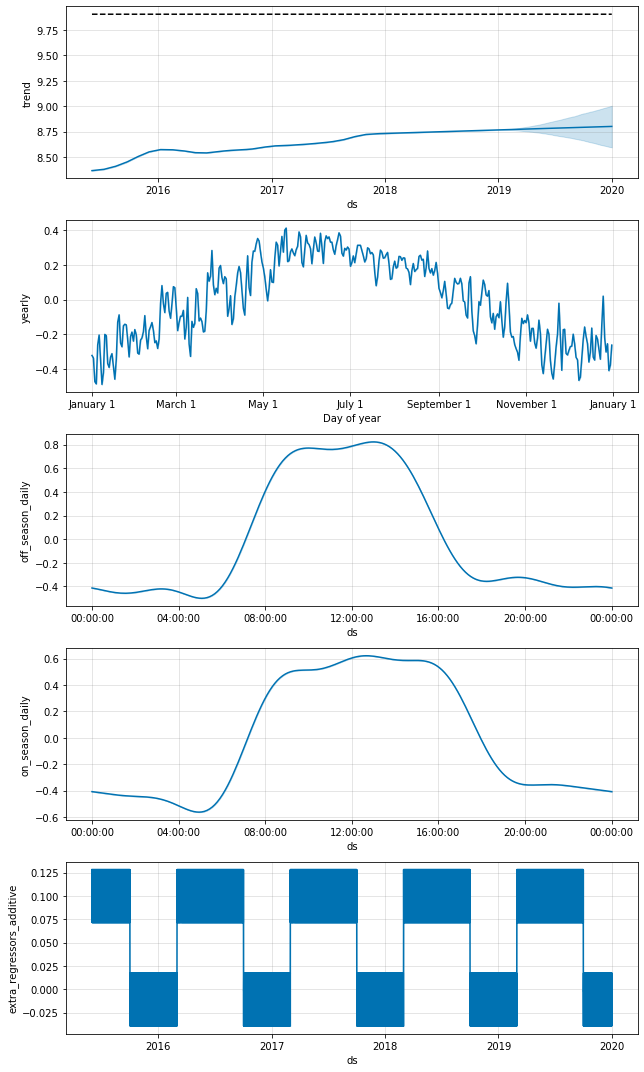

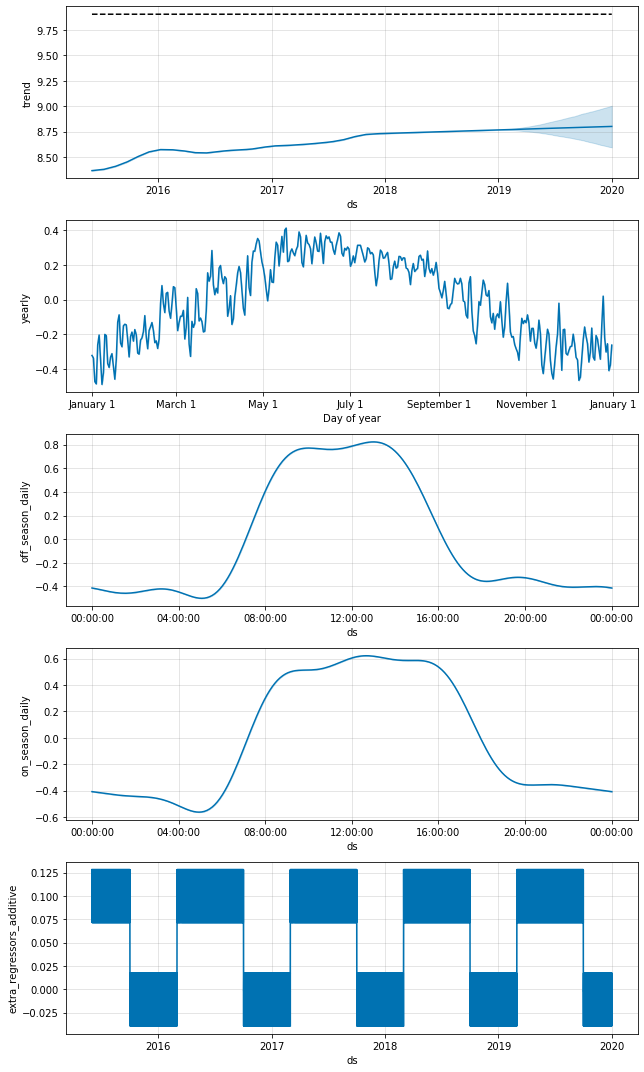

In [43]:
model.plot_components(forcast)

In [44]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

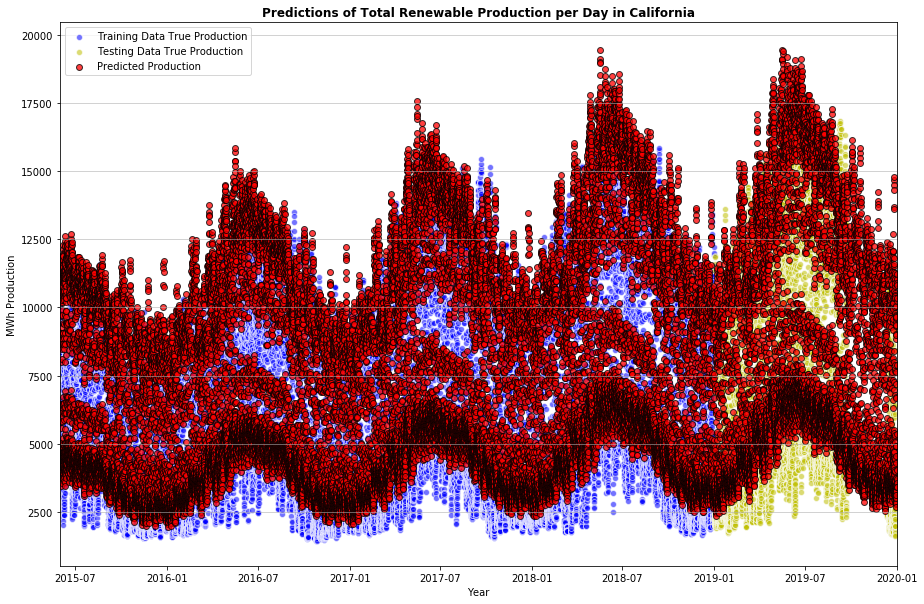

In [45]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  55314.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  7027.0


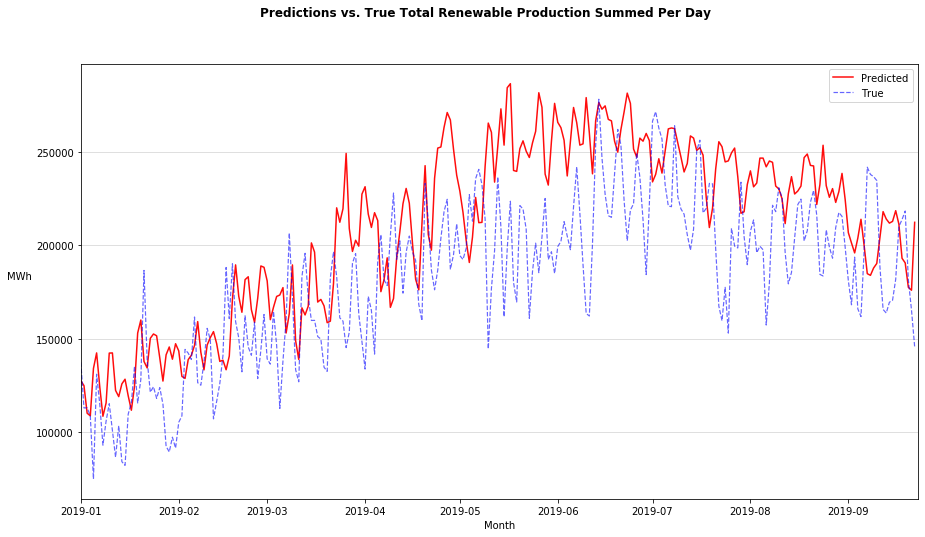

Train MAPE:  24.663356869731203
Train R2:  0.7923657199472331
Test MAPE:  27.560968446565145
Test R2:  0.7391068084043451


In [46]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])
#test data predictions and true values
tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),
                  how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)

#for plotting
dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values


#for plotting
datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'y'].values


month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))

plt.show()

#for calculations, training data
yhat_train = pd.DataFrame(forcast.loc[(forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[(dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])
#combine above two into one for calculations on training data 
tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum(np.nan_to_num(np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/true)),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [69]:
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['SOLAR TOTAL']
#daily_renew = y.resample('4H').sum()
daily_renew = y
dd_s = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month > 3) & (date.month < 11)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 10:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1



dd_s.columns = ['ds','y']

scaler = StandardScaler()

dd_s['cap'] = np.cbrt(15000)
dd_s['floor'] = 0
#dd_s['cap'] = np.log(dd['cap'])

dd_s['on_season'] = dd_s['ds'].apply(on_season)
dd_s['off_season'] = ~dd_s['ds'].apply(on_season)
dd_s['daytime'] = dd_s['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd_s['on_seasonr'] = dd_s['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
#dd['y'] = dd['y'].replace(0,dd['y'].median())
dd_s['y'] = np.cbrt(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
#dd_s['y'] = np.log(dd_s['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_season'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd_s['daytime'].values
daytimev = daytimev.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd_s['daytime'] = scaler.fit_transform(daytimev)

dd_s_train = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2016'))&(dd_s['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_s_train.head(8))

dd_s_train.info()

ds         y        cap  floor  on_season  off_season  \
5136 2016-01-01 00:00:00  0.000000  24.662121      0      False        True   
5137 2016-01-01 01:00:00  0.000000  24.662121      0      False        True   
5138 2016-01-01 02:00:00  0.000000  24.662121      0      False        True   
5139 2016-01-01 03:00:00  0.000000  24.662121      0      False        True   
5140 2016-01-01 04:00:00  0.000000  24.662121      0      False        True   
5141 2016-01-01 05:00:00  0.000000  24.662121      0      False        True   
5142 2016-01-01 06:00:00  0.000000  24.662121      0      False        True   
5143 2016-01-01 07:00:00  9.020529  24.662121      0      False        True   

       daytime  on_seasonr  
5136 -0.816497           0  
5137 -0.816497           0  
5138 -0.816497           0  
5139 -0.816497           0  
5140 -0.816497           0  
5141 -0.816497           0  
5142 -0.816497           0  
5143 -0.816497           0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26256 entries, 5136 to 31391
Data columns (total 8 columns):
ds            26256 non-null datetime64[ns]
y             26256 non-null float64
cap           26256 non-null float64
floor         26256 non-null int64
on_season     26256 non-null bool
off_season    26256 non-null bool
daytime       26256 non-null float64
on_seasonr    26256 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(2)
memory usage: 1.5 MB


In [70]:
model = Prophet(changepoint_range=.7,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.01,seasonality_prior_scale=20)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=10,prior_scale=1)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=10,prior_scale=1)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
#model.add_regressor('daytime',standardize=False)
#model.add_regressor('equinox')
#model.add_regressor('on_seasonr',standardize=False)
#model.add_regressor('year')
model.fit(dd_s_train)



In [71]:
futures = model.make_future_dataframe(periods=365*24,freq='1H')
futures['on_season'] = futures['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
futures['off_season'] = ~futures['ds'].apply(on_season)
futures['daytime'] = futures['ds'].apply(daytime)
futures['on_seasonr'] = futures['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
futures['cap'] = np.cbrt(15000)
futures['floor'] = 0
#futures['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = futures['daytime'].values
daytimef = daytimef.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
futures['daytime'] = scaler.fit_transform(daytimef)

forcasts = model.predict(futures)

ds     trend        cap  floor  yhat_lower  yhat_upper  \
35011 2019-12-31 19:00:00  9.260634  24.662121      0   -2.668184    1.986148   
35012 2019-12-31 20:00:00  9.260656  24.662121      0   -3.030212    1.511460   
35013 2019-12-31 21:00:00  9.260678  24.662121      0   -2.834159    1.825673   
35014 2019-12-31 22:00:00  9.260700  24.662121      0   -2.982721    1.660637   
35015 2019-12-31 23:00:00  9.260722  24.662121      0   -2.672028    1.630910   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  ...  \
35011     9.100896     9.404052       -9.551969             -9.551969  ...   
35012     9.100893     9.404097       -9.957616             -9.957616  ...   
35013     9.100889     9.404142       -9.736793             -9.736793  ...   
35014     9.100886     9.404186       -9.993781             -9.993781  ...   
35015     9.100882     9.404231       -9.859550             -9.859550  ...   

       on_season_daily  on_season_daily_lower  on_season_daily_upper  \
35011              0.0                    0.0                    0.0   
35012              0.0                    0.0                    0.0   
35013              0.0                    0.0                    0.0   
35014              0.0                    0.0                    0.0   
35015              0.0                    0.0                    0.0   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
35011 -3.031848     -3.031848     -3.031848                   0.0   
35012 -3.020656     -3.020656     -3.020656                   0.0   
35013 -3.005272     -3.005272     -3.005272                   0.0   
35014 -2.985905     -2.985905     -2.985905                   0.0   
35015 -2.962799     -2.962799     -2.962799                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper      yhat  
35011                         0.0                         0.0 -0.291335  
35012                         0.0                         0.0 -0.696960  
35013                         0.0                         0.0 -0.476115  
35014                         0.0                         0.0 -0.733080  
35015                         0.0                         0.0 -0.598827  

[5 rows x 24 columns]

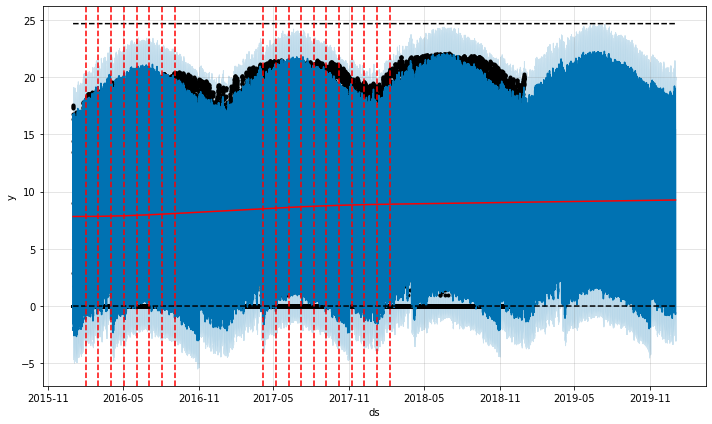

In [72]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forcasts)
a = add_changepoints_to_plot(fig.gca(), model, forcasts)
forcasts.tail()

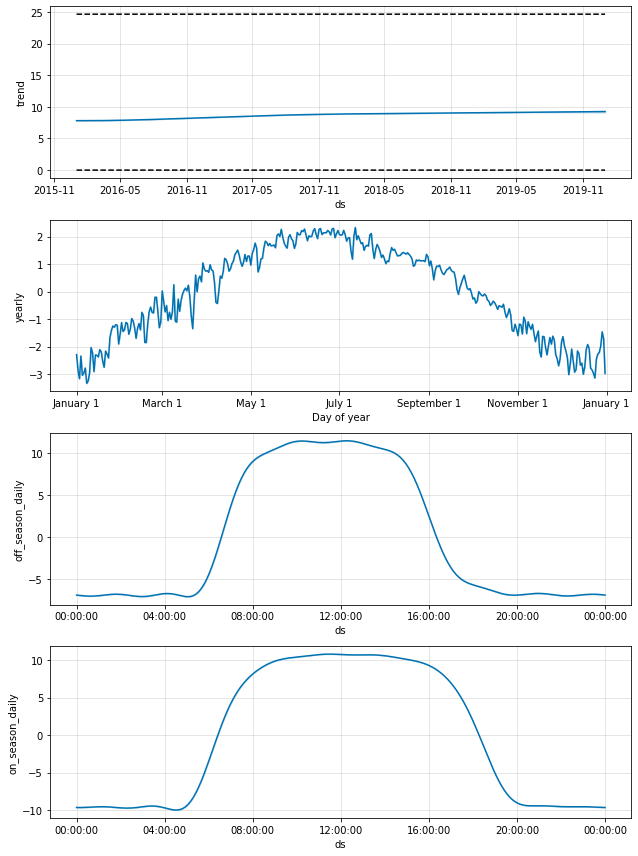

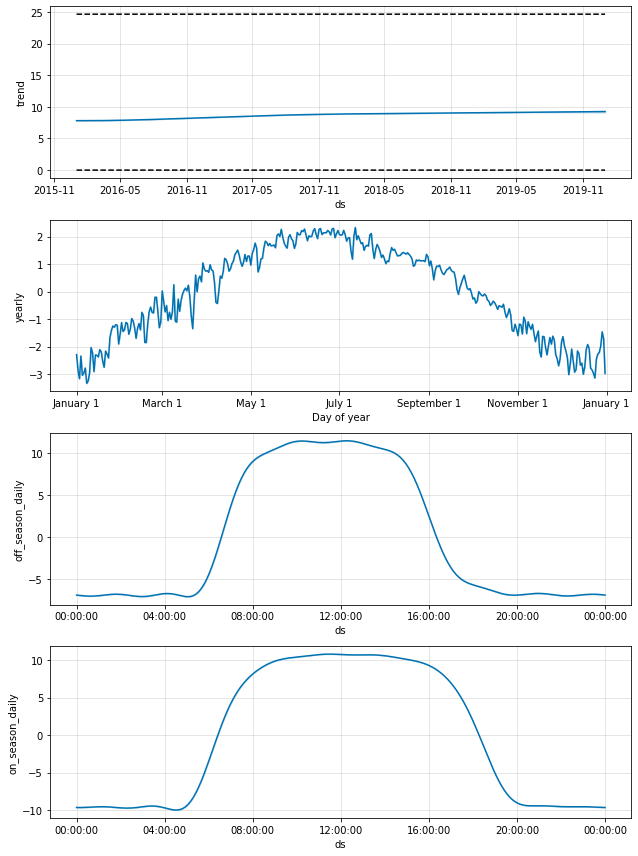

In [73]:
model.plot_components(forcasts)

In [74]:
#dd_s['y'] = np.exp(dd['y'])
dd_s['y'] = (dd_s['y'])**3
#dd_s_train['y'] = np.exp(dd_s_train['y'])
dd_s_train['y'] = (dd_s_train['y'])**3
#forcasts['yhst'] = np.exp(forcast['yhat'])
forcasts['yhat'] = (forcasts['yhat'])**3
dd_s_test = dd_s.loc[dd_s['ds']>pd.to_datetime('01/01/2019')]

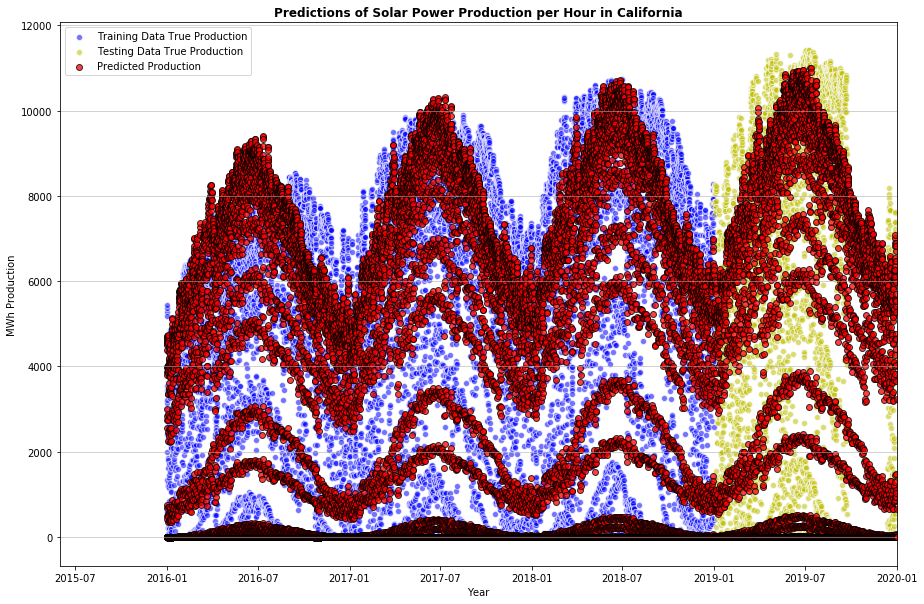

In [75]:

plt.figure(figsize=(15,10))

plt.scatter(dd_s_train['ds'],dd_s_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_s_test['ds'],dd_s_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcasts['ds'],forcasts['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('01/01/2020'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Solar Power Production per Hour in California",fontweight='bold')
plt.show()

Predicted total solar Production 2017:  20701.0
True total solar Production 2017:  22684.0
Error in year total prediction in GWh:  -1983.0


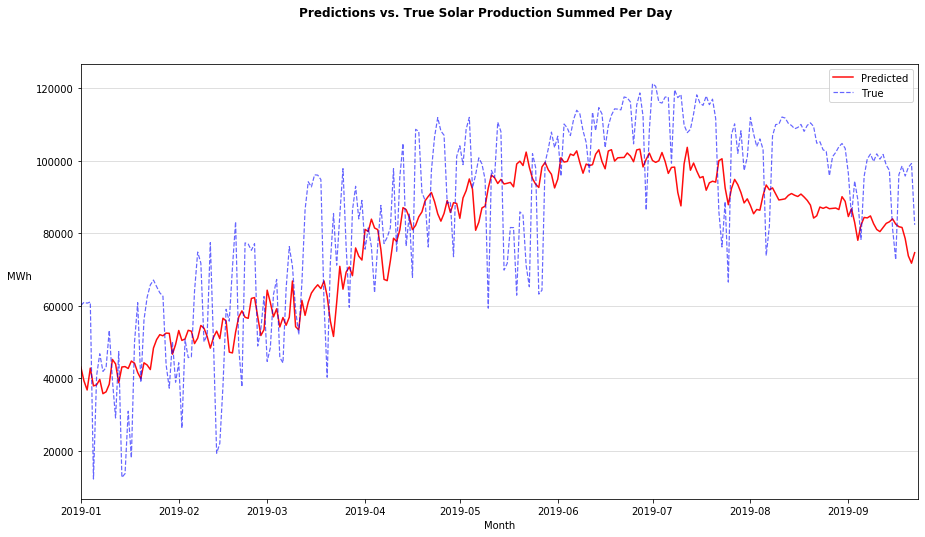

C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning:

divide by zero encountered in double_scalars



Test MAPE:  inf
Train R2:  0.9381460374598125
Test MAPE:  inf
Test R2:  0.9139126797704799


C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning:

divide by zero encountered in double_scalars



In [76]:
yhats = pd.DataFrame(forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                                   (forcasts['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
trues = pd.DataFrame(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (dd_s['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

testers = pd.merge(yhats.set_index(pd.DatetimeIndex(yhats['ds'])),(trues.set_index(pd.DatetimeIndex(trues['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted total solar Production 2017: ',(testers['yhat'].sum())//1000)
print('True total solar Production 2017: ',testers['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (testers['yhat'].sum()-testers['y'].sum())//1000)


datafs = forcasts.loc[((forcasts['ds'] >= pd.to_datetime('01/01/2019')) & \
                       (forcasts['ds'] < pd.to_datetime('09/23/2019'))),:].\
set_index(pd.DatetimeIndex(forcasts.loc[((forcasts['ds'] >= pd.to_datetime\
                                          ('01/01/2019')) & (forcasts['ds'] \
                                                             < pd.to_datetime\
                                                             ('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'yhat'].values



datats = dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                   (dd_s['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd_s.loc[((dd_s['ds'] >= pd.to_datetime('01/01/2019')) & \
                            (dd_s['ds'] < pd.to_datetime('09/23/2019'))),'ds']))\
.resample('24H').sum().loc[:,'y'].values

month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,datafs,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datats,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Solar Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
#plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_trains = pd.DataFrame(forcasts.loc[\
                                         (forcasts['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_trains = pd.DataFrame(dd_s.loc[\
                                     (dd_s['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_trains = pd.merge(yhat_trains.set_index(pd.DatetimeIndex(yhat_trains['ds'])),(true_trains.set_index(pd.DatetimeIndex(true_trains['ds']))),how='left',left_index=True,right_index=True)


tester_trains['msem'] = ((tester_trains['y']-tester_trains['yhat'])**2)
tester_trains['mseb'] = (tester_trains['y']-tester_trains['y'].mean())**2
r2 = 1 - ((np.sum(tester_trains['msem'])/len(tester_trains))/(np.sum(tester_trains['mseb'])/len(tester_trains)))
true_trains = tester_trains['y'].values
yhat_trains = tester_trains['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/np.nan_to_num(true))),true_trains,yhat_trains)))*(100/len(true_trains))
print('Test MAPE: ', mape)
print('Train R2: ',r2)


testers['msem'] = ((testers['y']-testers['yhat'])**2)
testers['mseb'] = (testers['y']-testers['y'].mean())**2
r2 = 1 - ((np.sum(testers['msem'])/len(testers))/(np.sum(testers['mseb'])/len(testers)))
true_tests = testers['y'].values
yhat_tests = testers['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/(true))),true_tests,yhat_tests)))))*100)/len(true_tests)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [114]:
 
full_data = full_data.set_index(pd.DatetimeIndex(full_data['timestamp']))

y = full_data['TOTAL']

daily_renew = y
dd = pd.DataFrame(daily_renew).reset_index()


def on_seasonr(ds):
    date = pd.to_datetime(ds)
    if ((date.month >= 3) & (date.month <= 9)):
        return 1
    else:
        return 0

def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month > 3) & (date.month < 11))

def daytime(ds):
    date = pd.to_datetime(ds)
    if ((date.hour <= 7)|(date.hour > 19)):
        return -1
    elif date.hour <= 11:
        return 0
    elif date.hour <=16:
        return 2
    elif date.hour <=19:
        return 0
    
def equinox(ds):
    date = pd.to_datetime(ds)
    if ((date <= pd.to_datetime('03-20-{}'.format(date.year))) & (date >= pd.to_datetime('02-01-{}'.format(date.year)))):
        return 0
    elif date <= pd.to_datetime('06-20-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('09-22-{}'.format(date.year)):
        return 2
    elif date <= pd.to_datetime('12-01-{}'.format(date.year)):
        return 0
    else:
        return -1
def get_year(ds):
    date = pd.to_datetime(ds)
    if date.year <= 2014:
        return -2
    elif date.year <= 2015:
        return -1
    elif date.year <= 2016:
        return 0
    elif date.year <= 2017:
        return 1
    elif date.year <= 2018:
        return 2


dd.columns = ['ds','y']

dd_sm = forcasts.loc[:,['ds','yhat']]
print('''forcasts.loc[:,['ds','yhat']].head()''')
display(forcasts.loc[:,['ds','yhat']].head())

dd = pd.merge(dd.set_index(pd.DatetimeIndex(dd['ds'])),(dd_sm.set_index(pd.DatetimeIndex(dd_sm['ds']))),
              how='left',left_index=True,right_index=True)
dd = dd.reset_index()
dd.drop(columns=['ds_x','ds_y'],inplace=True)
dd.columns = ['ds','y','solar']
display(dd.head())


scaler = StandardScaler()

dd['cap'] = 25000
dd['cap'] = np.log(dd['cap'])

dd['on_season'] = dd['ds'].apply(on_season)
dd['off_season'] = ~dd['ds'].apply(on_season)
dd['daytime'] = dd['ds'].apply(daytime)
#dd['equinox'] = dd['ds'].apply(equinox)
dd['on_seasonr'] = dd['ds'].apply(on_seasonr)
#dd['year'] = dd['ds'].apply(get_year)
dd['y'] = dd['y'].replace(0,dd['y'].median())
#dd['y'] = np.cbrt(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])
dd['y'] = np.log(dd['y'])
#dd['y'] = 1/np.sqrt(dd['y'])

#on_seasonv = dd['on_seasonr'].values
#on_seasonv = on_seasonv.reshape(-1,1)

#equinoxv = dd['equinox'].values
#equinoxv = equinoxv.reshape(-1,1)

daytimev = dd['daytime'].values
daytimev = daytimev.reshape(-1,1)

solarv = dd['solar'].values
solarv = solarv.reshape(-1,1)

#yearv = dd['year'].values
#yearv = yearv.reshape(-1,1)

#dd['year'] = scaler.fit_transform(yearv)
#dd['equinox'] =  scaler.fit_transform(equinoxv)
dd['daytime'] = scaler.fit_transform(daytimev)
dd['solar'] = scaler.fit_transform(solarv)

dd_train = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2016'))&(dd['ds'] < pd.to_datetime('01/01/2019')))])


display(dd_train.head(8))

dd_train.info()

forcasts.loc[:,['ds','yhat']].head()


ds      yhat
0 2016-01-01 00:00:00 -8.607923
1 2016-01-01 01:00:00 -9.201218
2 2016-01-01 02:00:00 -6.824538
3 2016-01-01 03:00:00 -9.606900
4 2016-01-01 04:00:00 -5.278378

ds     y  solar
0 2015-06-01 00:00:00  4669    NaN
1 2015-06-01 01:00:00  4396    NaN
2 2015-06-01 02:00:00  4197    NaN
3 2015-06-01 03:00:00  4059    NaN
4 2015-06-01 04:00:00  3694    NaN

ds         y     solar        cap  on_season  \
5136 2016-01-01 00:00:00  7.942007 -0.808483  10.126631      False   
5137 2016-01-01 01:00:00  7.929487 -0.808654  10.126631      False   
5138 2016-01-01 02:00:00  7.909122 -0.807970  10.126631      False   
5139 2016-01-01 03:00:00  7.920083 -0.808770  10.126631      False   
5140 2016-01-01 04:00:00  7.945910 -0.807526  10.126631      False   
5141 2016-01-01 05:00:00  7.919720 -0.808544  10.126631      False   
5142 2016-01-01 06:00:00  7.916807 -0.805950  10.126631      False   
5143 2016-01-01 07:00:00  8.101072 -0.611497  10.126631      False   

      off_season   daytime  on_seasonr  
5136        True -0.795932           0  
5137        True -0.795932           0  
5138        True -0.795932           0  
5139        True -0.795932           0  
5140        True -0.795932           0  
5141        True -0.795932           0  
5142        True -0.795932           0  
5143        True -0.795932           0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26256 entries, 5136 to 31391
Data columns (total 8 columns):
ds            26256 non-null datetime64[ns]
y             26256 non-null float64
solar         26256 non-null float64
cap           26256 non-null float64
on_season     26256 non-null bool
off_season    26256 non-null bool
daytime       26256 non-null float64
on_seasonr    26256 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(4), int64(1)
memory usage: 1.5 MB


In [115]:
#Something off with the on/ off season daily seasonality, likely high fourier order


#Fits pretty well this way without using the solar as an extra regressor
#Gonna fit a model for wind and one for other smaller sources then try to 
# Just add those combinations together and see how it compares to this model below 


model = Prophet(changepoint_range=.45,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=0.05,seasonality_prior_scale=15)
#model.add_seasonality(name='monthly',period=30.5, fourier_order=3)
model.add_seasonality(name='on_season_daily',period=1,condition_name='on_season', fourier_order=10,prior_scale=.001)
model.add_seasonality(name='off_season_daily',period=1,condition_name='off_season', fourier_order=10,prior_scale=.001)
#model.add_seasonality(name='equinox',period=365//4,fourier_order=10//4)
model.add_regressor('daytime',standardize=False)
# model.add_regressor('solar',standardize=False)
model.add_regressor('on_seasonr',standardize=False)
#model.add_regressor('year')
model.fit(dd_train)



In [116]:
future = model.make_future_dataframe(periods=365*24,freq='1H')

dd_smf = forcasts.loc[:,['ds','yhat']]

future = pd.merge(future.set_index(pd.DatetimeIndex(future['ds'])),(dd_smf.set_index(pd.DatetimeIndex(dd_smf['ds']))),how='left',left_index=True,right_index=True)
future = future.reset_index()
future.drop(columns=['ds_x','ds_y'],inplace=True)

future.info()
future.loc[(future['ds'] > pd.to_datetime('09/23/2019'))&(future['ds']< pd.to_datetime('12/16/2019'))].tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35016 entries, 0 to 35015
Data columns (total 2 columns):
ds      35016 non-null datetime64[ns]
yhat    35016 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 547.2 KB


ds      yhat
34627 2019-12-15 19:00:00  0.000100
34628 2019-12-15 20:00:00 -0.058183
34629 2019-12-15 21:00:00 -0.008013
34630 2019-12-15 22:00:00 -0.121604
34631 2019-12-15 23:00:00 -0.065963

In [117]:
future.rename(columns={
    'yhat':'solar'
}, inplace=True)
future['on_season'] = future['ds'].apply(on_season)
#future['equinox'] = future['ds'].apply(equinox)
future['off_season'] = ~future['ds'].apply(on_season)
future['daytime'] = future['ds'].apply(daytime)
future['on_seasonr'] = future['ds'].apply(on_seasonr)
#future['year'] = future['ds'].apply(get_year)
future['cap'] = 25000
future['cap'] = np.log(future['cap'])

#yearf = future['on_season'].values
#yearf = yearf.reshape(-1,1)

#equinoxf = future['equinox'].values
#equinoxf = equinoxf.reshape(-1,1)

daytimef = future['daytime'].values
daytimef = daytimef.reshape(-1,1)

solarf = future['solar'].values
solarf = solarf.reshape(-1,1)

#future['year'] = scaler.fit_transform(yearf)
#future['equinox'] = scaler.fit_transform(equinoxf)
future['daytime'] = scaler.fit_transform(daytimef)
future['solar'] = scaler.fit_transform(solarf)

display(future.head())


ds     solar  on_season  off_season   daytime  on_seasonr  \
0 2016-01-01 00:00:00 -0.807695      False        True -0.795932           0   
1 2016-01-01 01:00:00 -0.807867      False        True -0.795932           0   
2 2016-01-01 02:00:00 -0.807179      False        True -0.795932           0   
3 2016-01-01 03:00:00 -0.807985      False        True -0.795932           0   
4 2016-01-01 04:00:00 -0.806731      False        True -0.795932           0   

         cap  
0  10.126631  
1  10.126631  
2  10.126631  
3  10.126631  
4  10.126631

In [118]:
forcast = model.predict(future)

ds     trend        cap  yhat_lower  yhat_upper  \
35011 2019-12-31 19:00:00  8.774944  10.126631    7.856458    8.479356   
35012 2019-12-31 20:00:00  8.774954  10.126631    7.834872    8.448222   
35013 2019-12-31 21:00:00  8.774963  10.126631    7.822852    8.409660   
35014 2019-12-31 22:00:00  8.774972  10.126631    7.810865    8.403410   
35015 2019-12-31 23:00:00  8.774981  10.126631    7.799884    8.405266   

       trend_lower  trend_upper  additive_terms  additive_terms_lower  \
35011     8.752316     8.797984       -0.608976             -0.608976   
35012     8.752322     8.797999       -0.624212             -0.624212   
35013     8.752328     8.798014       -0.642944             -0.642944   
35014     8.752334     8.798028       -0.674896             -0.674896   
35015     8.752340     8.798039       -0.671784             -0.671784   

       additive_terms_upper  ...  on_seasonr  on_seasonr_lower  \
35011             -0.608976  ...         0.0               0.0   
35012             -0.624212  ...         0.0               0.0   
35013             -0.642944  ...         0.0               0.0   
35014             -0.674896  ...         0.0               0.0   
35015             -0.671784  ...         0.0               0.0   

       on_seasonr_upper    yearly  yearly_lower  yearly_upper  \
35011               0.0 -0.303923     -0.303923     -0.303923   
35012               0.0 -0.305526     -0.305526     -0.305526   
35013               0.0 -0.307221     -0.307221     -0.307221   
35014               0.0 -0.308983     -0.308983     -0.308983   
35015               0.0 -0.310787     -0.310787     -0.310787   

       multiplicative_terms  multiplicative_terms_lower  \
35011                   0.0                         0.0   
35012                   0.0                         0.0   
35013                   0.0                         0.0   
35014                   0.0                         0.0   
35015                   0.0                         0.0   

       multiplicative_terms_upper      yhat  
35011                         0.0  8.165968  
35012                         0.0  8.150742  
35013                         0.0  8.132018  
35014                         0.0  8.100076  
35015                         0.0  8.103197  

[5 rows x 32 columns]

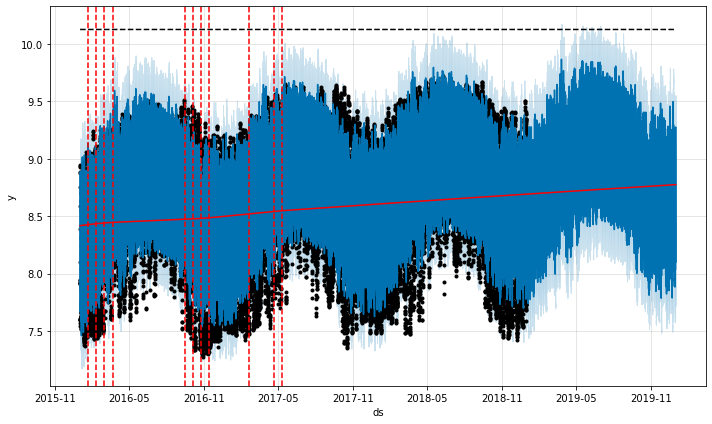

In [119]:
fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), model, forcast)
forcast.tail()

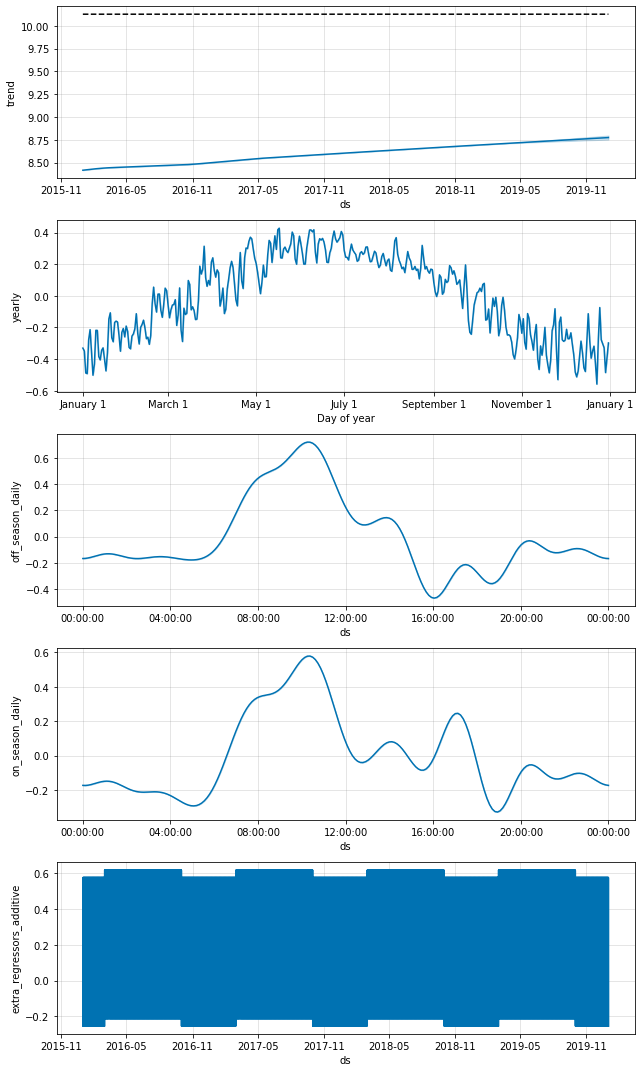

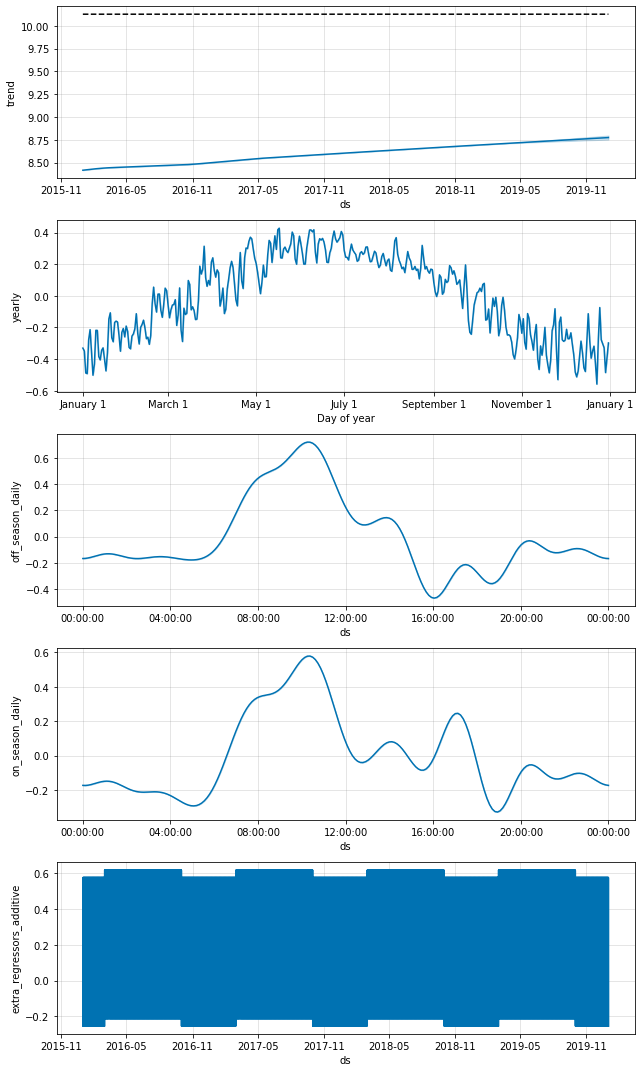

In [120]:
model.plot_components(forcast)

In [121]:
dd['y'] = np.exp(dd['y'])
#dd['y'] = (dd['y'])**3
dd_train['y'] = np.exp(dd_train['y'])
#dd_train['y'] = (dd_train['y'])**3
forcast['yhat'] = np.exp(forcast['yhat'])
#forcast['yhat'] = (forcast['yhat'])**3
dd_test = dd.loc[dd['ds']>pd.to_datetime('01/01/2019')]

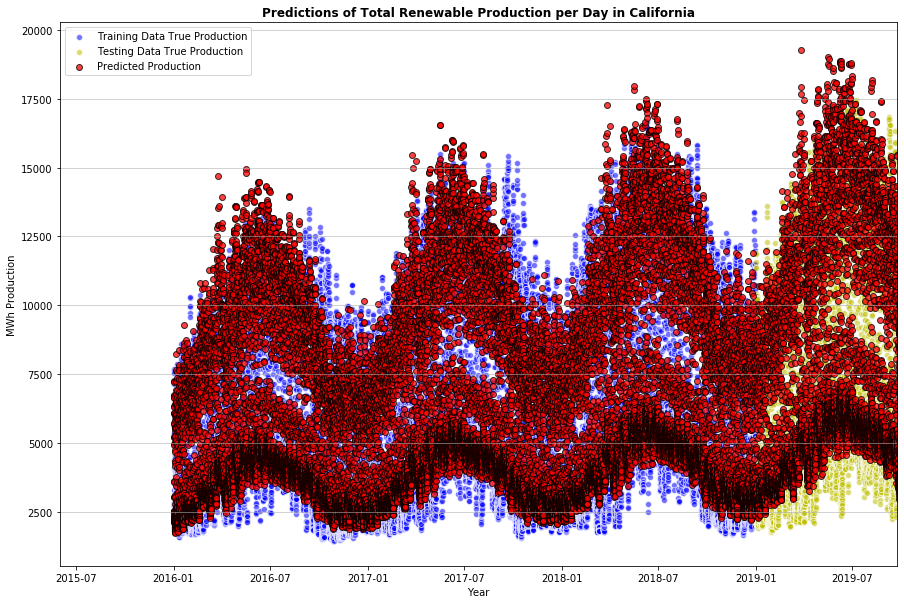

In [122]:

plt.figure(figsize=(15,10))

plt.scatter(dd_train['ds'],dd_train['y'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(dd_test['ds'],dd_test['y'],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forcast['ds'],forcast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

plt.xlim(pd.to_datetime('06/01/2015'),pd.to_datetime('09/23/2019'))
plt.ylabel('MWh Production')
plt.xlabel('Year')
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)
plt.title("Predictions of Total Renewable Production per Day in California",fontweight='bold')
plt.show()

Predicted Total Renewable Production 2019:  50465.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  2178.0


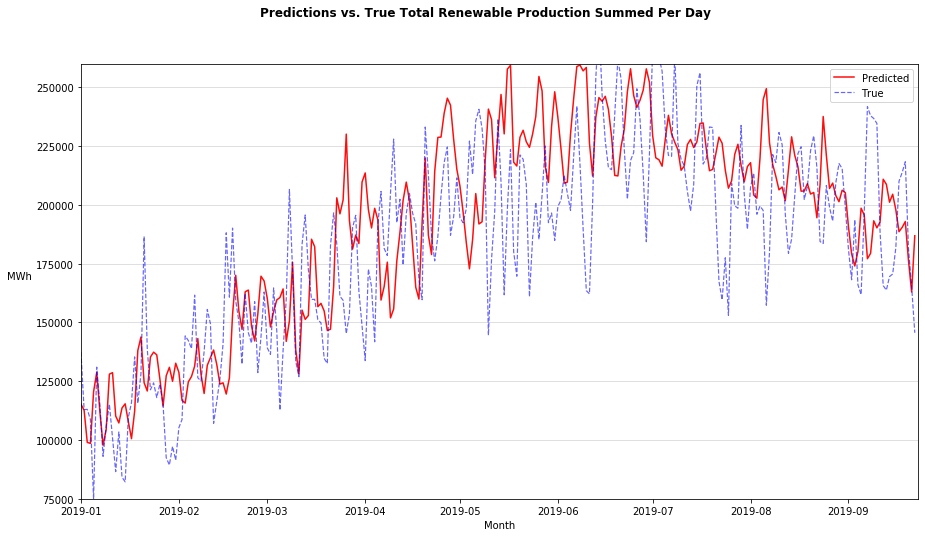

Train MAPE:  18.775931974914226
Train R2:  0.8629021558492702
Test MAPE:  22.220680725987673
Test R2:  0.8070416412302914


In [123]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('24H').sum().loc[:,'yhat'].values


datat = dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('24H').sum().loc[:,'y'].values



month_list = pd.date_range('01/01/2019','09/22/2019 23:00:00',freq='24H')


plt.figure(figsize=(15,8))
plt.plot(month_list,dataf,label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(month_list,datat,label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Day',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
plt.ylim(bottom=75000,top=260000)
plt.show()

yhat_train = pd.DataFrame(forcast.loc[\
                                       (forcast['ds'] < pd.to_datetime('01/01/2019')),['yhat','ds']])
true_train = pd.DataFrame(dd.loc[\
                                  (dd['ds'] < pd.to_datetime('01/01/2019')),['y','ds']])

tester_train = pd.merge(yhat_train.set_index(pd.DatetimeIndex(yhat_train['ds'])),
                        (true_train.set_index(pd.DatetimeIndex(true_train['ds']))),
                        how='left',left_index=True,right_index=True)


tester_train['msem'] = ((tester_train['y']-tester_train['yhat'])**2)
tester_train['mseb'] = (tester_train['y']-tester_train['y'].mean())**2
r2 = 1 - ((np.sum(tester_train['msem'])/len(tester_train))/(np.sum(tester_train['mseb'])/len(tester_train)))
true_train = tester_train['y'].values
yhat_train = tester_train['yhat'].values
mape = np.sum(list(map((lambda true,yhat : np.abs((true - yhat)/true)),true_train,yhat_train)))*(100/len(true_train))
print('Train MAPE: ', mape)
print('Train R2: ',r2)
    


tester['msem'] = ((tester['y']-tester['yhat'])**2)
tester['mseb'] = (tester['y']-tester['y'].mean())**2
r2 = 1 - ((np.sum(tester['msem'])/len(tester))/(np.sum(tester['mseb'])/len(tester)))
true_test = tester['y'].values
yhat_test = tester['yhat'].values
mape2 = (np.sum((np.array(list(map((lambda true,yhat : (np.abs(true - yhat)/np.nan_to_num(true))),true_test,yhat_test)))))*100)/len(true_test)
print('Test MAPE: ', mape2)

print('Test R2: ',r2)


In [124]:
forcast['solar'] = forcasts['yhat']
predictions = forcast.loc[:,['ds','solar','yhat']]
predictions.rename(columns={
    'ds':'timestamp',
    'solar':'Pred Solar Prod',
    'yhat':'Pred Tot Renew Prod'
}, inplace=True)
predictions['Hour'] = predictions['timestamp'].dt.hour
predictions = predictions[['timestamp','Hour','Pred Tot Renew Prod','Pred Solar Prod']]
predictions.head(24)

timestamp  Hour  Pred Tot Renew Prod  Pred Solar Prod
0  2016-01-01 00:00:00     0          2173.016569        -8.607923
1  2016-01-01 01:00:00     1          2246.077701        -9.201218
2  2016-01-01 02:00:00     2          2185.136479        -6.824538
3  2016-01-01 03:00:00     3          2176.686212        -9.606900
4  2016-01-01 04:00:00     4          2176.291887        -5.278378
5  2016-01-01 05:00:00     5          2130.996043        -8.820076
6  2016-01-01 06:00:00     6          2290.683615         0.201782
7  2016-01-01 07:00:00     7          3043.861316       676.410046
8  2016-01-01 08:00:00     8          5224.825596      2845.087810
9  2016-01-01 09:00:00     9          5721.509983      3857.433621
10 2016-01-01 10:00:00    10          6744.432520      4618.565129
11 2016-01-01 11:00:00    11          6101.753236      4541.192157
12 2016-01-01 12:00:00    12          7246.177939      4708.392097
13 2016-01-01 13:00:00    13          6347.409258      4512.600793
14 2016-01-01 14:00:00    14          6662.439707      3978.573157
15 2016-01-01 15:00:00    15          4978.482244      2743.537545
16 2016-01-01 16:00:00    16          3618.201245       502.361350
17 2016-01-01 17:00:00    17          2535.032089         6.178969
18 2016-01-01 18:00:00    18          2529.982558        -0.006299
19 2016-01-01 19:00:00    19          2398.695811        -0.921513
20 2016-01-01 20:00:00    20          2366.777742        -2.593956
21 2016-01-01 21:00:00    21          2327.475170        -1.547538
22 2016-01-01 22:00:00    22          2259.002955        -2.895982
23 2016-01-01 23:00:00    23          2270.918342        -2.253003

In [125]:
# name = 'hourlyrenewablepredictions'
# schema = 'Predictions'

# with engine.connect() as c:
#     c.execute('''CREATE SCHEMA "Predictions"''')

# predictions.to_sql(name=name, con=con, schema=schema, if_exists='replace',index=False)

In [126]:
# with engine.connect() as c:
#     c.execute('''ALTER TABLE "Predictions".hourlyrenewablepredictions 
#     ADD PRIMARY KEY ("timestamp")''')

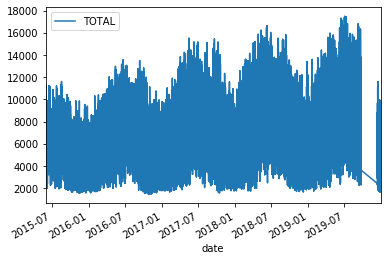

In [127]:
full_data.plot(x='date',
              y='TOTAL')

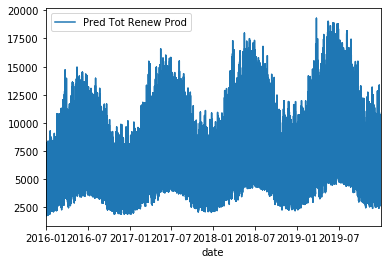

In [128]:
predictions['date'] = pd.to_datetime(predictions['timestamp']).dt.date
predictions.plot(x='date',
              y='Pred Tot Renew Prod')

In [129]:
from sklearn.metrics import mean_absolute_error as MAE
#train Mean Absolute Error 
MAE(tester_train['y'], tester_train['yhat'])

993.5029242064968

In [130]:
#test mae
MAE(tester['y'], tester['yhat'])

1359.8095246553107

Predicted Total Renewable Production 2019:  50465.0
True Total Renewable Production 2019:  48286.0
Error in year total prediction in GWh:  2178.0


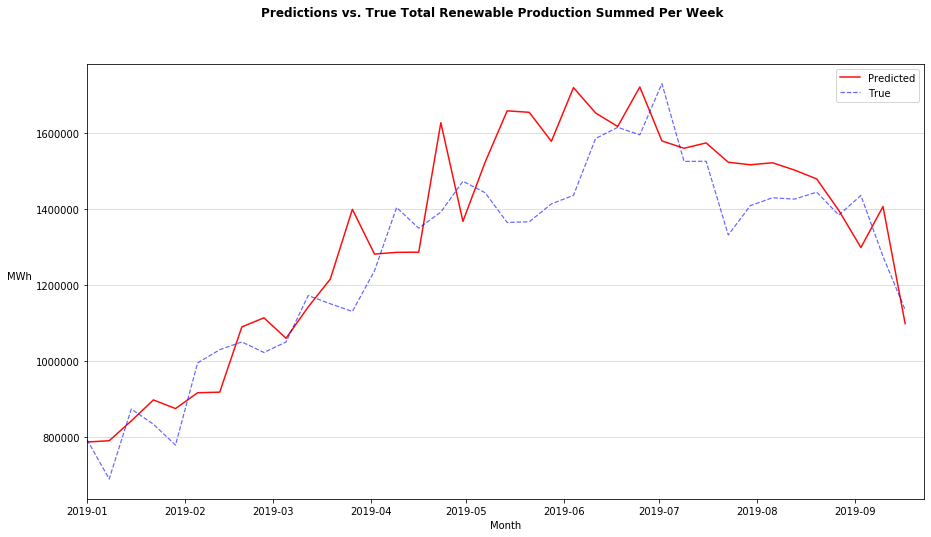

In [131]:
yhat = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                                 (forcast['ds'] < pd.to_datetime('09/23/2019'))),['yhat','ds']])
true = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & (dd['ds'] < pd.to_datetime('09/23/2019'))),['y','ds']])

tester = pd.merge(yhat.set_index(pd.DatetimeIndex(yhat['ds'])),(true.set_index(pd.DatetimeIndex(true['ds']))),how='left',left_index=True,right_index=True)
#display(tester.head())

print('Predicted Total Renewable Production 2019: ',(tester['yhat'].sum())//1000)
print('True Total Renewable Production 2019: ',tester['y'].sum()//1000)
print('Error in year total prediction in GWh: ', (tester['yhat'].sum()-tester['y'].sum())//1000)


dataf = pd.DataFrame(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                     (forcast['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(forcast.loc[((forcast['ds'] >= pd.to_datetime('01/01/2019')) & \
                               (forcast['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).\
resample('7D').sum().loc[:,'yhat'])


datat = pd.DataFrame(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                (dd['ds'] < pd.to_datetime('09/23/2019'))),:].set_index\
(pd.DatetimeIndex(dd.loc[((dd['ds'] >= pd.to_datetime('01/01/2019')) & \
                          (dd['ds'] < pd.to_datetime('09/23/2019'))),'ds'])).resample('7D').sum().loc[:,'y'])



month_list = pd.date_range('01/01/2019','09/23/2019',freq='1M')


plt.figure(figsize=(15,8))
plt.plot(dataf.index,dataf.reset_index()['yhat'],label='Predicted',linewidth=1.5,alpha=.95,color='r')
plt.plot(datat.index,datat.reset_index()['y'],label='True',linewidth=1.2, alpha=.6,color='b',ls='--')
plt.legend()
plt.suptitle('Predictions vs. True Total Renewable Production Summed Per Week',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('MWh',rotation='0',ha='right')
plt.grid(axis='y',alpha=.5)
plt.xlim(pd.to_datetime('01/01/2019'),pd.to_datetime('09/23/2019'))
# plt.ylim(bottom=75000,top=260000)
plt.show()




(50000, 272468.45519499126)

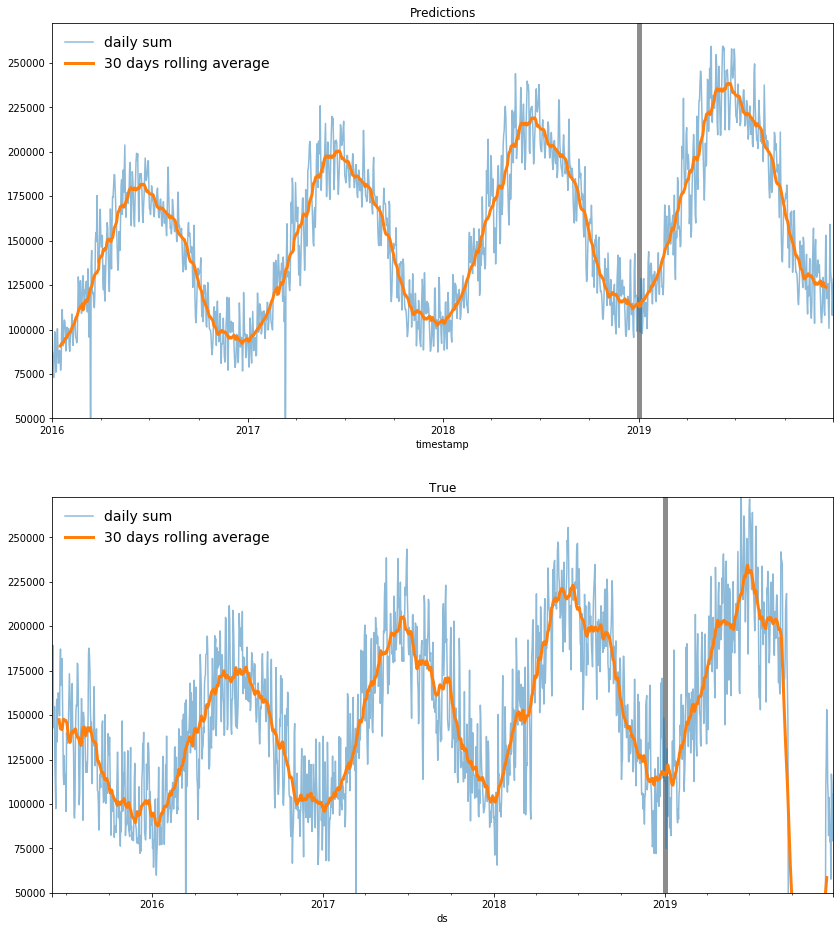

In [132]:
data = pd.DataFrame(predictions['Pred Tot Renew Prod']).set_index(pd.DatetimeIndex(predictions['timestamp'])).resample('1D').sum()
pd.plotting.register_matplotlib_converters()
f, axes = plt.subplots(nrows=2, figsize=(14,16), sharey=True)

ax = axes[0]

data.plot(ax=ax, alpha=0.5, title="Predictions")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)

ax = axes[1]

data = pd.DataFrame(dd['y']).set_index(pd.DatetimeIndex(dd['ds'])).resample('1D').sum()
data.plot(ax=ax, alpha=0.5, title="True")
data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3)
ax.legend(['daily sum','30 days rolling average'], frameon=False, fontsize=14)
ax.axvline(pd.to_datetime('2019-01-01'),lw=5,color='k',alpha=.45,zorder=-1)
ax.set_ylim(bottom=50000)


In [97]:

sns.jointplot(x=full_data.loc[full_data['date'] < pd.to_datetime('09/23/2019'),'TOTAL'].values,y=predictions.loc[predictions['timestamp'] < pd.to_datetime('09/23/2019'),
                                                                                         'Pred Tot Renew Prod'])

KeyError: 'TOTAL'